<a href="https://colab.research.google.com/github/tisRobin/BERT_Research_Project/blob/main/2_Formatting%2C_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference :

https://www.guru99.com/tokenize-words-sentences-nltk.html

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import nltk
from nltk import tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
report = open("/content/gdrive/Shareddrives/Senior Thesis Report/Research Project/Platform Economy Asia+Europe.txt")

In [4]:
raw_report = report.read()

In [5]:
# split text into a list of sentences using NLTK

report = tokenize.sent_tokenize(raw_report)

In [6]:
len(report)

3674

In [7]:
import pandas as pd
split_report = pd.DataFrame(report)

In [8]:
split_report.columns = ['pre_sentence']

In [9]:
split_report[50:55]

,pre_sentence
50,It is not easy to find the right balance in re...
51,"Many, if not all, advanced nations are still \..."
52,With a thriving Platform \nEconomy and Southea...
53,The Platform Economy can be a powerful force f...
54,While this report does not seek to provide any...


In [10]:
# Cleaning

def remove_newline(string):
  new_sen = string.replace('\n'," ")
  new_sen2 = new_sen.replace('\x02', '')
  return new_sen2

In [11]:
split_report['Sentence'] = split_report['pre_sentence'].apply(remove_newline)

In [12]:
split_report.drop('pre_sentence', inplace=True, axis=1)

In [13]:
split_report[50:55]

,Sentence
50,It is not easy to find the right balance in re...
51,"Many, if not all, advanced nations are still ..."
52,With a thriving Platform Economy and Southeas...
53,The Platform Economy can be a powerful force f...
54,While this report does not seek to provide any...


In [14]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [16]:
# reload the saved model from directory, along with tokenizer 


new_model = DistilBertForSequenceClassification.from_pretrained("/content/gdrive/Shareddrives/Senior Thesis Report/Research Project/distilbert_platform_growth")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")

In [17]:
from transformers import pipeline

In [18]:
clf = pipeline("text-classification", new_model, tokenizer = tokenizer)

0 - negative 

1 - neutral

2 - positive

In [19]:
sample_sentence = 'The Platform Economy is a powerful force for stronger and inclusive development.'

In [20]:
clf(sample_sentence)

[{'label': 'LABEL_2', 'score': 0.8557952642440796}]

In [21]:
# df['Sentiment'] = df['Sentence'].apply(clf)

The above code produced a runtime error: "Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors"

This means some sentences (perhaps many) in my **split_report data**, when tokenized, have more than 512 tokens, rendering BERT unable to accept them for analysis. 


Therefore, I used a different approach for predicting sentiment, using my fine-tuned model and a function I created with the help of the github link below, The writer of the link is currently an active machine learning engineer who teaches AI-based NLP on various online platforms. 


His method enables BERT fine-tuned models to process any sentence regardless of length, and make classifications. However, he advises using it for longer text, like paragraphs or pages, since they usually contain more than one sentiment. So he recommends using it for sentence-based instances only. 

Reference



https://towardsdatascience.com/how-to-apply-transformers-to-any-length-of-text-a5601410af7f


https://github.com/jamescalam/transformers/blob/main/course/language_classification/03_long_text_sentiment.ipynb


In [22]:
import torch

In [23]:
def sentiment(txt):
  tokens = tokenizer.encode_plus(txt, add_special_tokens=False)
  input_ids = tokens['input_ids']
  attention_mask = tokens['attention_mask']

  # initialize probabilities list
  probs_list = []

  start = 0
  window_size = 510  # we take 2 off here so that we can fit in our [CLS] and [SEP] tokens
  # get the total length of our tokens
  total_len = len(input_ids)

  loop = True

  while loop:
      end = start + window_size
      if end >= total_len:
          loop = False
          end = total_len
      # (1) extract window from input_ids and attention_mask
      input_ids_chunk = input_ids[start:end]
      attention_mask_chunk = attention_mask[start:end]
      # (2) add [CLS] and [SEP]
      input_ids_chunk = [101] + input_ids_chunk + [102]
      attention_mask_chunk = [1] + attention_mask_chunk + [1]
      # (3) add padding upto window_size + 2 (512) tokens
      input_ids_chunk += [0] * (window_size - len(input_ids_chunk) + 2)
      attention_mask_chunk += [0] * (window_size - len(attention_mask_chunk) + 2)
      # (4) format into PyTorch tensors dictionary
      input_dict = {
          'input_ids': torch.Tensor([input_ids_chunk]).long(),
          'attention_mask': torch.Tensor([attention_mask_chunk]).int()
      }
      # (5) make logits prediction (output of BERTForSequenceClassification)
      outputs = new_model(**input_dict)
      # (6) calculate softmax and append to list
      probs = torch.nn.functional.softmax(outputs[0], dim=-1)
      probs_list.append(probs)

      start = end

  with torch.no_grad():
    # we must include our stacks operation in here too
    stacks = torch.stack(probs_list)
    # now resize
    stacks = stacks.resize_(stacks.shape[0], stacks.shape[2])
    # finally, we can calculate the mean value for each sentiment class
    mean = stacks.mean(dim=0)
  
  winner = torch.argmax(mean).item()
  return ['negative', 'neutral', 'positive'][winner]


In [24]:
sentiment(sample_sentence)

'positive'

In [25]:
sentiment('The platform underwent a series of sales losses, due to the careless management of the interface.')

'negative'

* Apply sentiment classification to every sentence

In [26]:
split_report['Sentiment'] = split_report['Sentence'].apply(sentiment)

Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


In [27]:
split_report[40:50]

,Sentence,Sentiment
40,The largest O2O verticals in Southeast Asia i...,neutral
41,"Note: 1 MSMEs refer to Micro, Small & Medium E...",positive
42,"Beyond Gross Merchandise Value (GMV) growth, P...",positive
43,"This report introduces the NPI, which assesses...",neutral
44,Two priorities stand out for Southeast Asia: ...,positive
45,"Consumers are able to enjoy better access, aff...",positive
46,MSMEs leveraging Platforms have also benefited...,positive
47,The rise of e-commerce has also contributed t...,positive
48,Executive summary As with any new technology ...,neutral
49,It will be important for countries in Southea...,neutral


In [28]:
split_report.to_csv('/content/gdrive/Shareddrives/Senior Thesis Report/Research Project/Report_sentiment.csv', index = None, header=True )

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

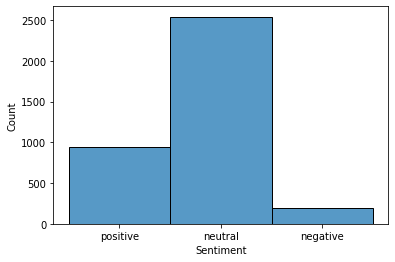

In [30]:
sns.histplot(data=split_report ,x='Sentiment')

In [31]:
len(split_report[split_report['Sentiment']=='positive'])

940

* I extract only the sentences classified as 'positive', to later perform topic modeling. 

In [32]:
pos_sent = split_report[split_report['Sentiment']=='positive']

In [33]:
pos_sent.to_csv('/content/gdrive/Shareddrives/Senior Thesis Report/Research Project/Platform Econ Pos.csv', index = None, header=True )